IMPORT ALL PACKAGES

In [33]:
import torch
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch.nn.functional as F
import seaborn as sns

from pathlib import Path
from PIL import Image, ImageEnhance
from collections import Counter, defaultdict
from IPython.display import Markdown

from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image

from scipy.ndimage import gaussian_filter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# add root directory to sys.path
sys.path.append(str(Path().resolve().parent))

from src.models import load_model, SimpleCNN, ComplexCNN, TransferResNet
from src.models import TransferModileNetV2, TransferResNetLarge
from src.dataloader import load_data, TumorDataset
from src.dataloader import LABEL_NAMES, MEAN, STD, IMAGENET_MEAN, IMAGENET_STD

DATA REVIEW AND PREPARATION

<small>Data is stored in ./raw_data under four different labels: Glioma, Meningioma, No Tumor, and Pituitary

In [3]:
# import raw data using "load_data" class written in src/dataloader.py
raw_data_path = r"../raw_data"

dataset = load_data(dataset_path=raw_data_path, 
                    transform_pipeline="raw",
                    return_dataloader=False)

print(f"Total Samples: {len(dataset)}")

Total Samples: 5712


In [ ]:
# create function to display helper functions used
def display_code_file(filepath):
    with open(filepath, 'r') as f:
        code = f.read()
    display(Markdown(f"```python\n{code}\n```"))

# display code in src/dataloader.py
display_code_file(r"..\src\dataloader.py")

```python
import csv
import torch

from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# image labels
LABEL_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]

# global size, image mean, image std
SIZE = (128, 128)
MEAN = [0.186]
STD = [0.179]
RESNET_SIZE = (224, 224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class TumorDataset(Dataset):
    """
    Brain Tumor Dataset for classification
    """
    def __init__(
        self,
        dataset_path: str,
        transform_pipeline: str = "default"
    ):
        self.transform = self.get_transform(transform_pipeline)
        self.data = []

        dataset_path = Path(dataset_path)

        for label in LABEL_NAMES:
            label_dir = dataset_path / label
            if not label_dir.exists():
                continue
            label_id = LABEL_NAMES.index(label) 

            for img_path in label_dir.glob("*.jpg"):
                self.data.append((img_path, label_id))

    def get_transform(self, transform_pipeline: str = "default"):
        xform = None

        if transform_pipeline == "raw":
            xform = transforms.Compose([
                transforms.ToTensor()
            ])

        if transform_pipeline == "default" or transform_pipeline =="validation":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.Resize(SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

        if transform_pipeline == "train":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.RandomResizedCrop(size=128, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.Resize(SIZE),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=15),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

        if transform_pipeline == "pretrained_validation":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(RESNET_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])

        if transform_pipeline == "pretrained_train":
            xform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=20),
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05),
                transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                transforms.ToTensor(),
                transforms.RandomErasing(p=0.25),
                transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ])
        
        if xform is None:
            raise ValueError(f"Invalid transform {transform_pipeline} specified")
        
        return xform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label_id = self.data[idx]
        img = Image.open(img_path).convert("RGB") # maybe remove .convert("RGB")
        data = (self.transform(img), label_id)

        return data
    

def load_data(
    dataset_path: str,
    transform_pipeline: str = "default",
    return_dataloader: bool = True,
    num_workers: int = 2,
    batch_size: int = 256,
    shuffle: bool = False
) -> DataLoader | Dataset:
    """
    Constructs the dataset or dataloader.

    Args:
        transform_pipeline (str): 'default', 'aug', or other custom transformation pipelines
        return_dataloader (bool): returnes either DataLoader or Dataset
        num_workers (int): data workers
        batch_size (int): batch size
        shuffle (bool): True for Train, False for Validation
    """
    dataset = TumorDataset(dataset_path, transform_pipeline=transform_pipeline)

    if not return_dataloader:
        return dataset
    
    return DataLoader(
        dataset,
        num_workers=num_workers,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=True
    )
```

In [ ]:
# find class distribtion
label_counts = Counter(label for _, label in dataset)

In [ ]:
# print distribtion
for i, class_name in enumerate(LABEL_NAMES):
    print(f"{class_name}: {label_counts[i]} samples")

glioma: 1321 samples
meningioma: 1339 samples
notumor: 1595 samples
pituitary: 1457 samples


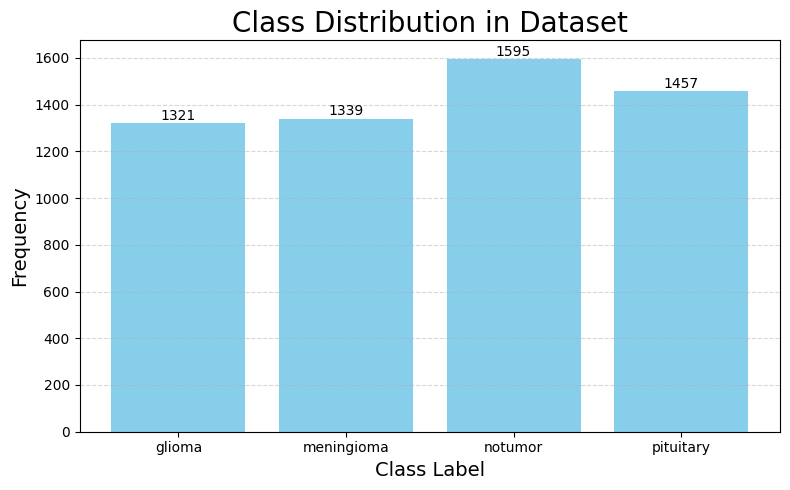

In [10]:
# visualize distribution
counts = [label_counts[i] for i in range(len(LABEL_NAMES))]

plt.figure(figsize=(8, 5))
bars = plt.bar(LABEL_NAMES, counts, color='skyblue')

for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, str(count),
             ha='center', va='bottom', fontsize=10)

plt.title("Class Distribution in Dataset", fontsize=20)
plt.xlabel("Class Label", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
# initialize other statistics
image_sizes = defaultdict(int)
brightness_values = []
channel_means = []
channel_stds = []

# analyze each image
for img, _ in dataset:
    img_np = img.numpy()
    size = img_np.shape[1:]
    image_sizes[size] += 1
    brightness_values.append(img_np.mean())
    channel_means.append(img_np.mean(axis=(1, 2)))
    channel_stds.append(img_np.std(axis=(1, 2)))

# convert to arrays
channel_means = np.stack(channel_means)
channel_stds = np.stack(channel_stds)

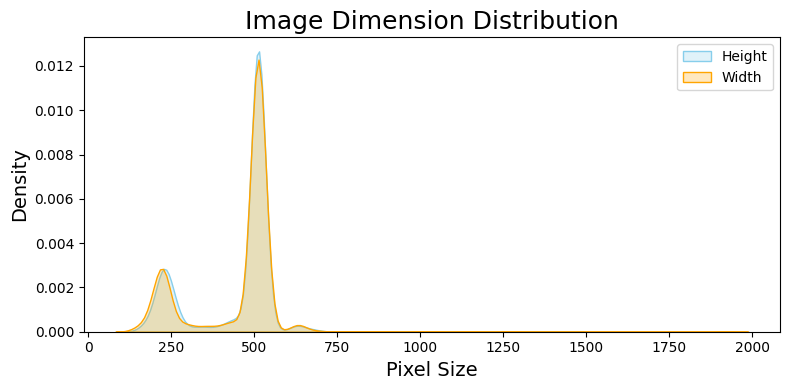

In [20]:
# plot image size distribution
heights = [size[0] for size in image_sizes.keys() for _ in range(image_sizes[size])]
widths = [size[1] for size in image_sizes.keys() for _ in range(image_sizes[size])]

plt.figure(figsize=(8, 4))
sns.kdeplot(heights, label="Height", color="skyblue", fill=True)
sns.kdeplot(widths, label="Width", color="orange", fill=True)
plt.title("Image Dimension Distribution", fontsize=18)
plt.xlabel("Pixel Size", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


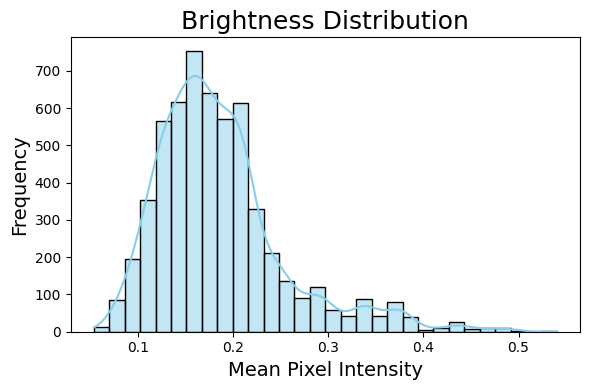

In [22]:
# plot brightness
plt.figure(figsize=(6, 4))
sns.histplot(brightness_values, bins=30, kde=True, color='skyblue')
plt.title("Brightness Distribution", fontsize=18)
plt.xlabel("Mean Pixel Intensity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

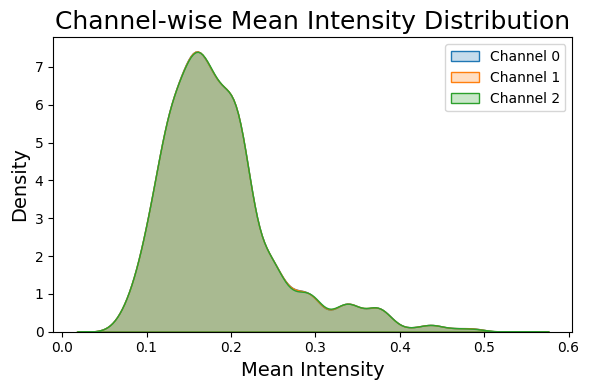

In [26]:
# plot channel-wise mean intensity
plt.figure(figsize=(6, 4))
for i in range(channel_means.shape[1]):
    sns.kdeplot(channel_means[:, i], label=f"Channel {i}", fill=True)
plt.title("Channel-wise Mean Intensity Distribution", fontsize=18)
plt.xlabel("Mean Intensity", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

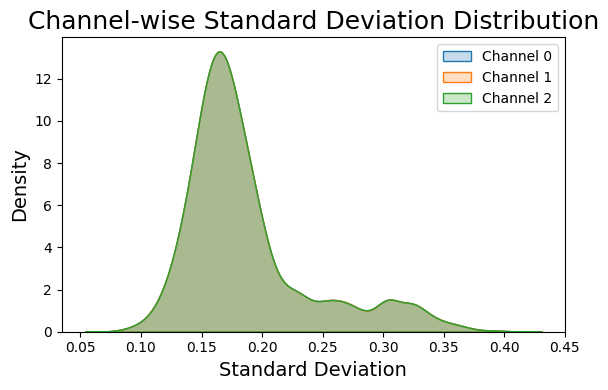

In [27]:
# plot channel-wise std intensity
plt.figure(figsize=(6, 4))
for i in range(channel_stds.shape[1]):
    sns.kdeplot(channel_stds[:, i], label=f"Channel {i}", fill=True)
plt.title("Channel-wise Standard Deviation Distribution", fontsize=18)
plt.xlabel("Standard Deviation", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

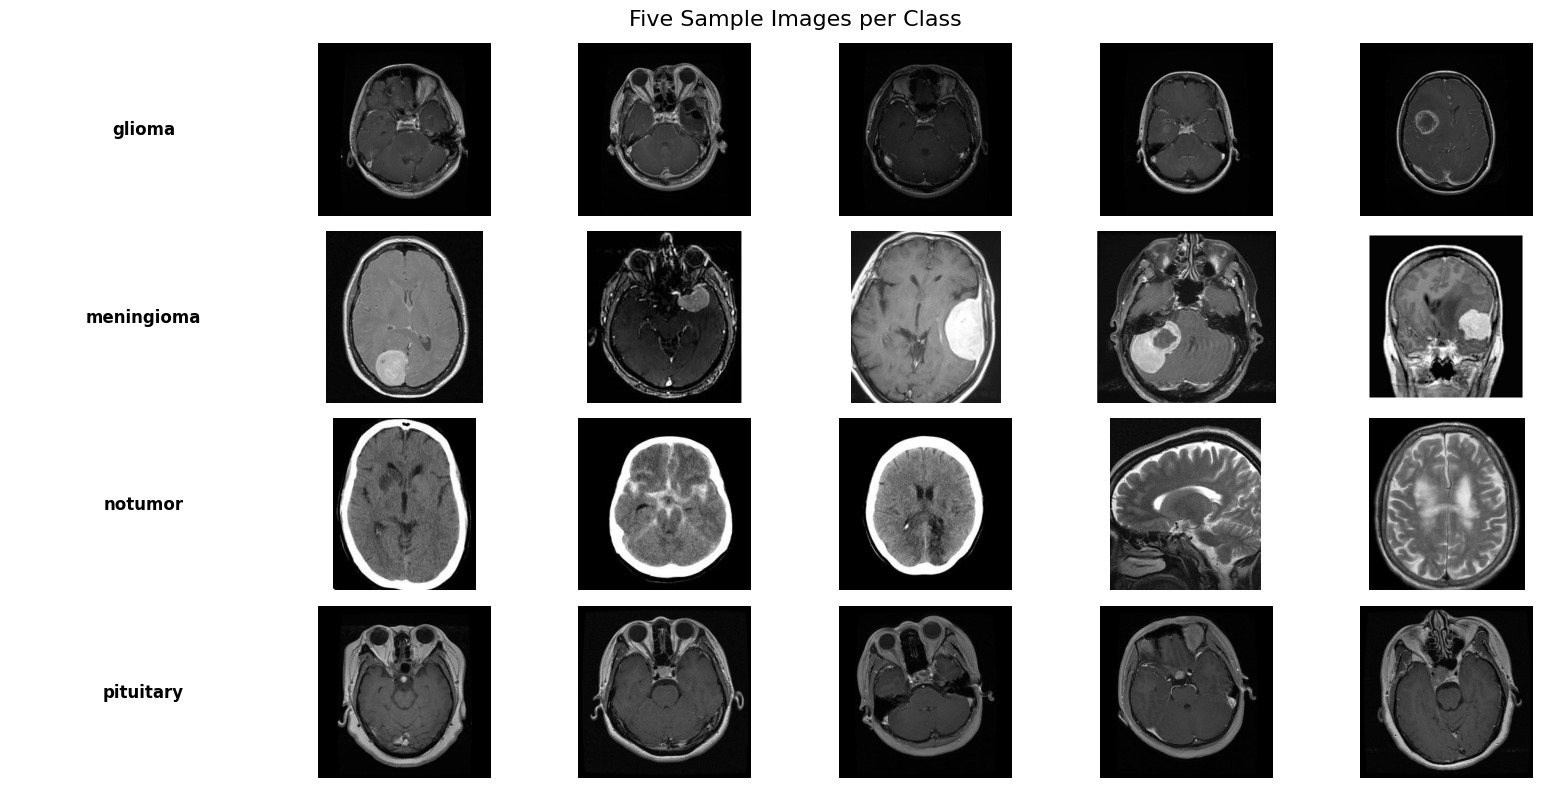

In [32]:
# organize images by label
samples_per_class = {i: [] for i in range(len(LABEL_NAMES))}
for img, label in dataset:
    if len(samples_per_class[label]) < 5:
        samples_per_class[label].append(img)
    if all(len(v) == 5 for v in samples_per_class.values()):
        break

# create an extra column for the labels
n_rows = len(LABEL_NAMES)
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols + 1, figsize=(16, 8))

for row_idx, (label_id, images) in enumerate(samples_per_class.items()):
    # create labels
    label_ax = axes[row_idx, 0]
    label_ax.axis("off")
    label_ax.text(0.5, 0.5, LABEL_NAMES[label_id], fontsize=12,
                  ha="center", va="center", weight="bold")
    
    for col_idx, img_tensor in enumerate(images):
        ax = axes[row_idx, col_idx + 1]
        img_np = img_tensor.numpy()

        if img_np.shape[0] == 1:
            ax.imshow(img_np[0], cmap="gray")
        else:
            ax.imshow(img_np.transpose(1, 2, 0))

        ax.axis("off")

plt.suptitle("Five Sample Images per Class", fontsize=16)
plt.tight_layout()
plt.show()

In [39]:
# data now needs to be simple into training, validation, testing groups
# this is done using the code in src/utils/split_dataset.py

display_code_file(r"../src/utils/split_dataset.py")

```python
import os
import shutil
import random

# function to clear target directory
def clear_directory(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

# split the dataset into train/test/split in a new directory
def split_dataset(
        source_dir='raw_data',
        dest_dir='data',
        splits=(0.7, 0.15, 0.15),
        seed=42
):
    assert sum(splits) == 1.0, "Splits must sum to 1.0"
    random.seed(seed)
    split_names = ['train', 'val', 'test']
    class_names = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    # clear and recreate destination directories
    for split in split_names:
        for cls in class_names:
            clear_directory(os.path.join(dest_dir, split, cls))

    # shuffle and copy files
    for cls in class_names:
        class_path = os.path.join(source_dir, cls)
        images = os.listdir(class_path)
        random.shuffle(images)
        total = len(images)
        train_end = int(splits[0] * total)
        val_end = train_end + int(splits[1] * total)

        subsets = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, files in subsets.items():
            for file in files:
                src = os.path.join(source_dir, cls, file)
                dst = os.path.join(dest_dir, split, cls, file)
                shutil.copy2(src, dst)

# main loop
if __name__ == "__main__":
    split_dataset()
```

In [41]:
# import the split data - use transform_pipeline="raw" for purposes of visualization
train_path = r"../data/train"
val_path = r"../data/val"
test_path = r"../data/test"


train_data = load_data(dataset_path=train_path,
                       transform_pipeline="raw", 
                       return_dataloader=False)

val_data = load_data(dataset_path=val_path,
                     transform_pipeline="raw",
                     return_dataloader=False)

test_data = load_data(dataset_path=test_path,
                      transform_pipeline="raw",
                      return_dataloader=False)

print(f"Train Samples: {len(train_data)}\n"
      f"Validation Samples: {len(val_data)}\n"
      f"Test Samples: {len(test_data)}")

Train Samples: 3996
Validation Samples: 855
Test Samples: 861


In [43]:
train_counts = Counter(label for _, label in train_data)
val_counts = Counter(label for _, label in val_data)
test_counts = Counter(label for _, label in test_data)

# print training distribtions
print("Training Distribution")
print('---------------------')
for i, class_name in enumerate(LABEL_NAMES):
    print(f"{class_name}: {train_counts[i]} samples")
print()

# print validation distributions
print("Validation Distribution")
print('-----------------------')
for i, class_name in enumerate(LABEL_NAMES):
    print(f"{class_name}: {val_counts[i]} samples")
print()

# print testing distributions
print("Testing Distribution")
print('--------------------')
for i, class_name in enumerate(LABEL_NAMES):
    print(f"{class_name}: {test_counts[i]} samples")

Training Distribution
---------------------
glioma: 924 samples
meningioma: 937 samples
notumor: 1116 samples
pituitary: 1019 samples

Validation Distribution
-----------------------
glioma: 198 samples
meningioma: 200 samples
notumor: 239 samples
pituitary: 218 samples

Testing Distribution
--------------------
glioma: 199 samples
meningioma: 202 samples
notumor: 240 samples
pituitary: 220 samples


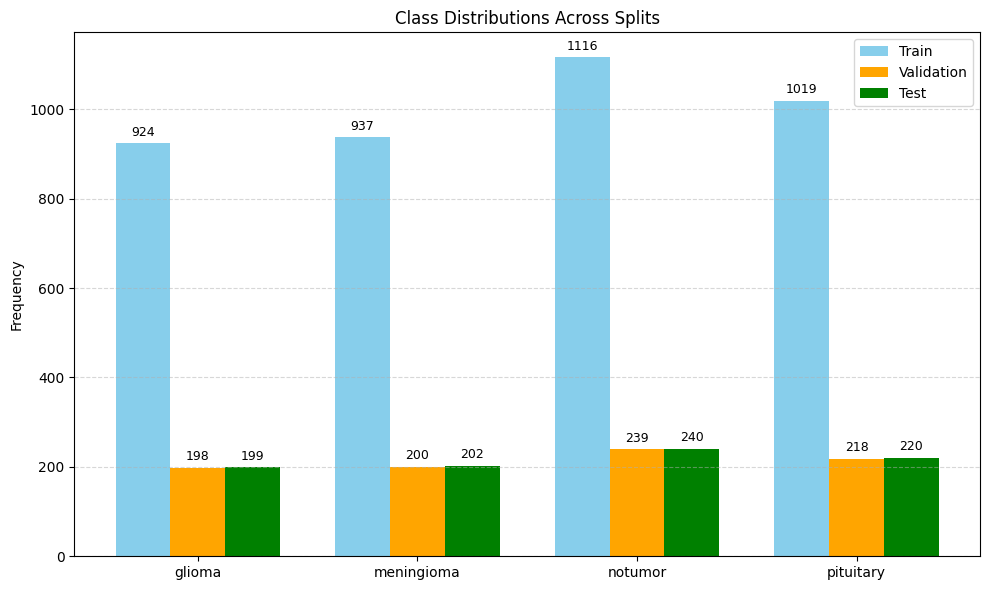

In [50]:
# bar plot distributions for each data set
x = np.arange(len(LABEL_NAMES))
bar_width = 0.25

# convert counters to lists
train_list = [train_counts[i] for i in range(len(train_counts))]
val_list = [val_counts[i] for i in range(len(val_counts))]
test_list = [test_counts[i] for i in range(len(test_counts))]

# plot the data
plt.figure(figsize=(10, 6))
train_bars = plt.bar(x - bar_width, train_list, width=bar_width, label="Train", color="skyblue")
val_bars = plt.bar(x, val_list, width=bar_width, label="Validation", color="orange")
test_bars = plt.bar(x + bar_width, test_list, width=bar_width, label="Test", color="green")

# helper function to plot value counts
def annotate_bars(bars, counts):
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2,
                 height + 10,
                 str(count),
                 ha='center',
                 va='bottom',
                 fontsize=9)

# annotate the plots
annotate_bars(train_bars, train_list)
annotate_bars(val_bars, val_list)
annotate_bars(test_bars, test_list)

# labels and title
plt.xticks(x, LABEL_NAMES)
plt.ylabel("Frequency")
plt.title("Class Distributions Across Splits")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()